In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('logins.json','r') as read_file:
    login_date = json.load(read_file)

In [3]:
login_series = np.array(list(login_date.values()))
ones = np.ones(len(login_series.T))
login_df = pd.DataFrame(login_series.T,columns=[list(login_date.keys())[0]])
login_df['count'] = ones
login_df.head()

,login_time,count
0,1970-01-01 20:13:18,1.0
1,1970-01-01 20:16:10,1.0
2,1970-01-01 20:16:37,1.0
3,1970-01-01 20:16:36,1.0
4,1970-01-01 20:26:21,1.0


In [4]:
login_df['login_time'] = login_df['login_time'].astype('datetime64')
login_df['login_time'] = pd.to_datetime(login_df['login_time'])

In [5]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
 1   count       93142 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 MB


In [6]:
logins_15m = login_df.groupby(pd.Grouper(freq='15T',key='login_time')).count()

In [7]:
login_df['month'], login_df['day'], login_df['week']= login_df['login_time'].dt.month, login_df['login_time'].dt.day, login_df['login_time'].dt.week

In [8]:
counts_by_day = login_df.groupby(login_df['day'])['count'].count()
counts_by_month = login_df.groupby(login_df['month'])['count'].count()
counts_by_week = login_df.groupby(['week']).count()

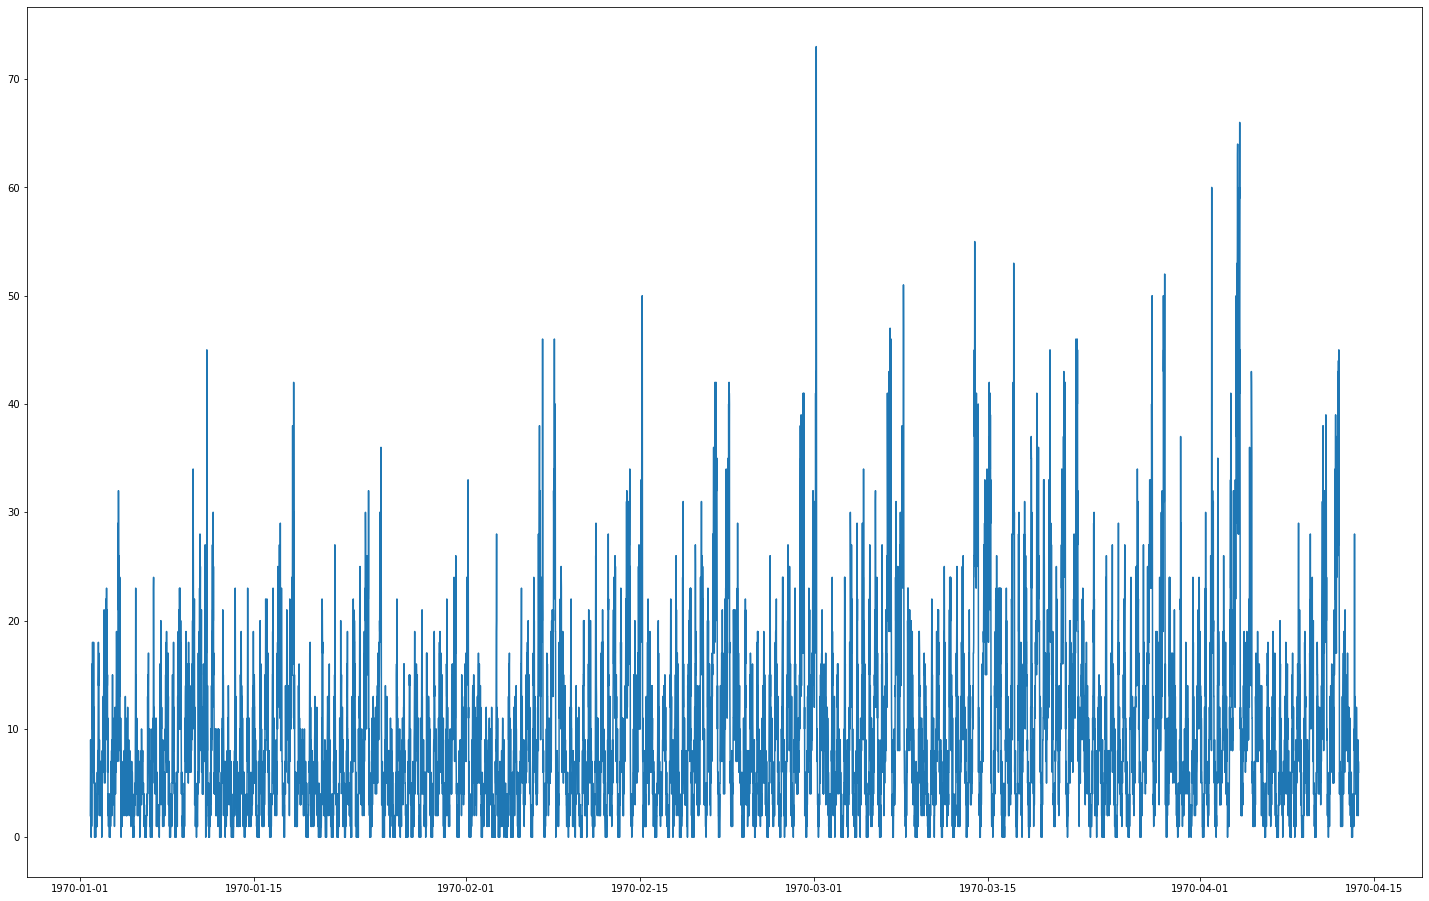

In [9]:
plt.figure(figsize=(25,16))
_=plt.plot(logins_15m)

This looks extremely busy and doesn't serve well for surfacing patterns, I will try aggregating in 3 hour increments instead

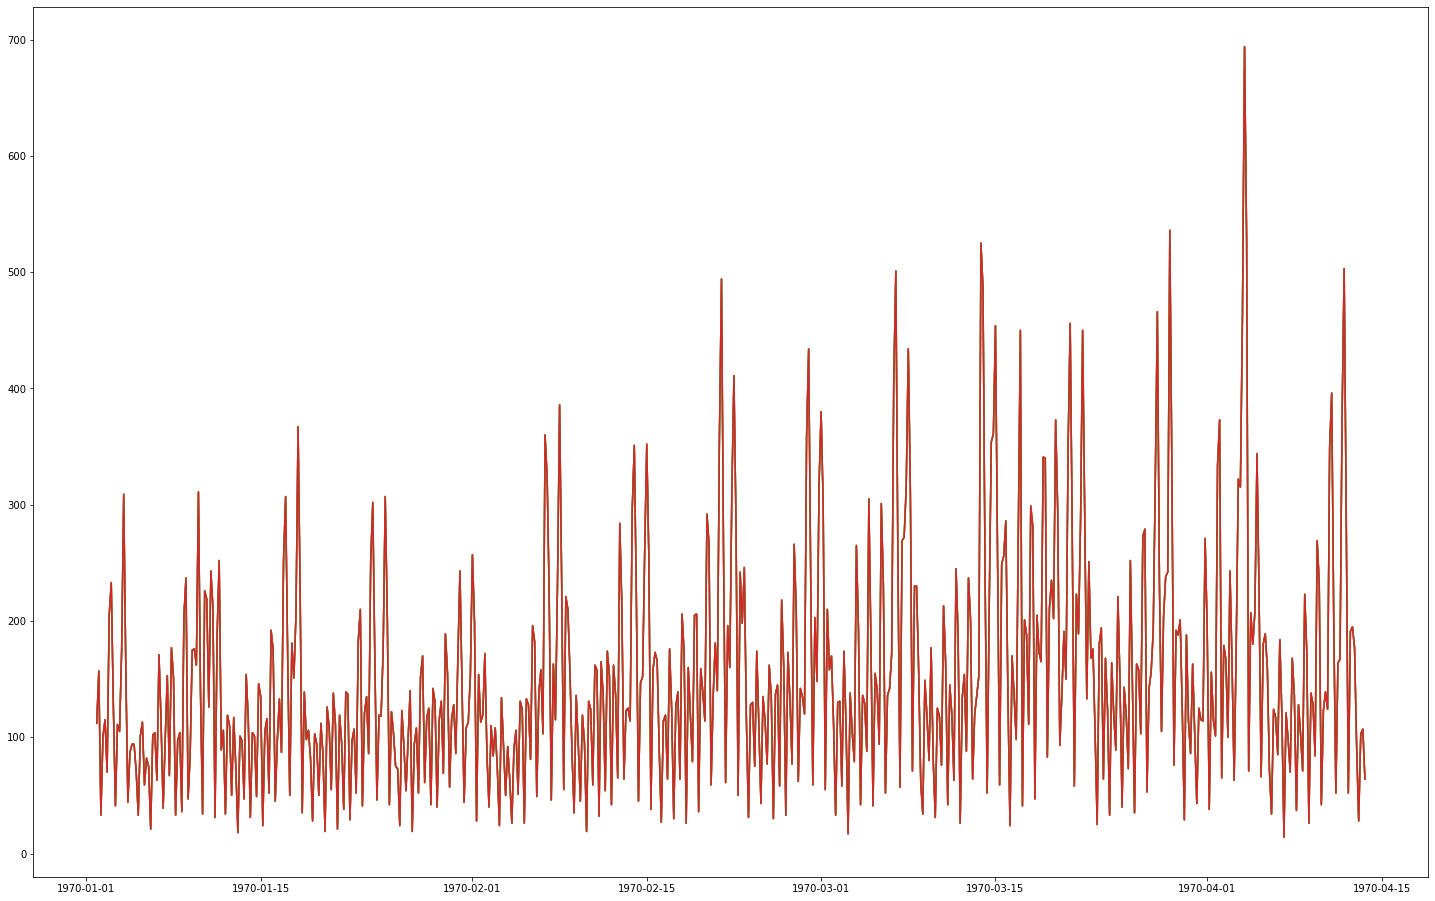

In [10]:
logins_4h = login_df.groupby(pd.Grouper(freq='4H',key='login_time')).count()
plt.figure(figsize=(25,16))
_=plt.plot(logins_4h)

Here we see a more of a cyclic daily/weekly patterns while the peaks appear to be increasing from january through april. Let's take a closer look at the daily cycle, the weekly cycle as well as the steady month over month increase

In [11]:
january = logins_15m['1970-01-01':'1970-02-01']
february = logins_15m['1970-02-01':'1970-03-01']
march = logins_15m['1970-03-01':'1970-04-01']
january_w_whole_month = logins_4h['1970-01-03':'1970-01-31']
january_first_week = logins_4h['1970-01-03':'1970-01-10']

In [12]:
january_weekend = logins_15m['1970-01-02':'1970-01-03']
january_weekday = logins_15m['1970-01-05':'1970-01-07']

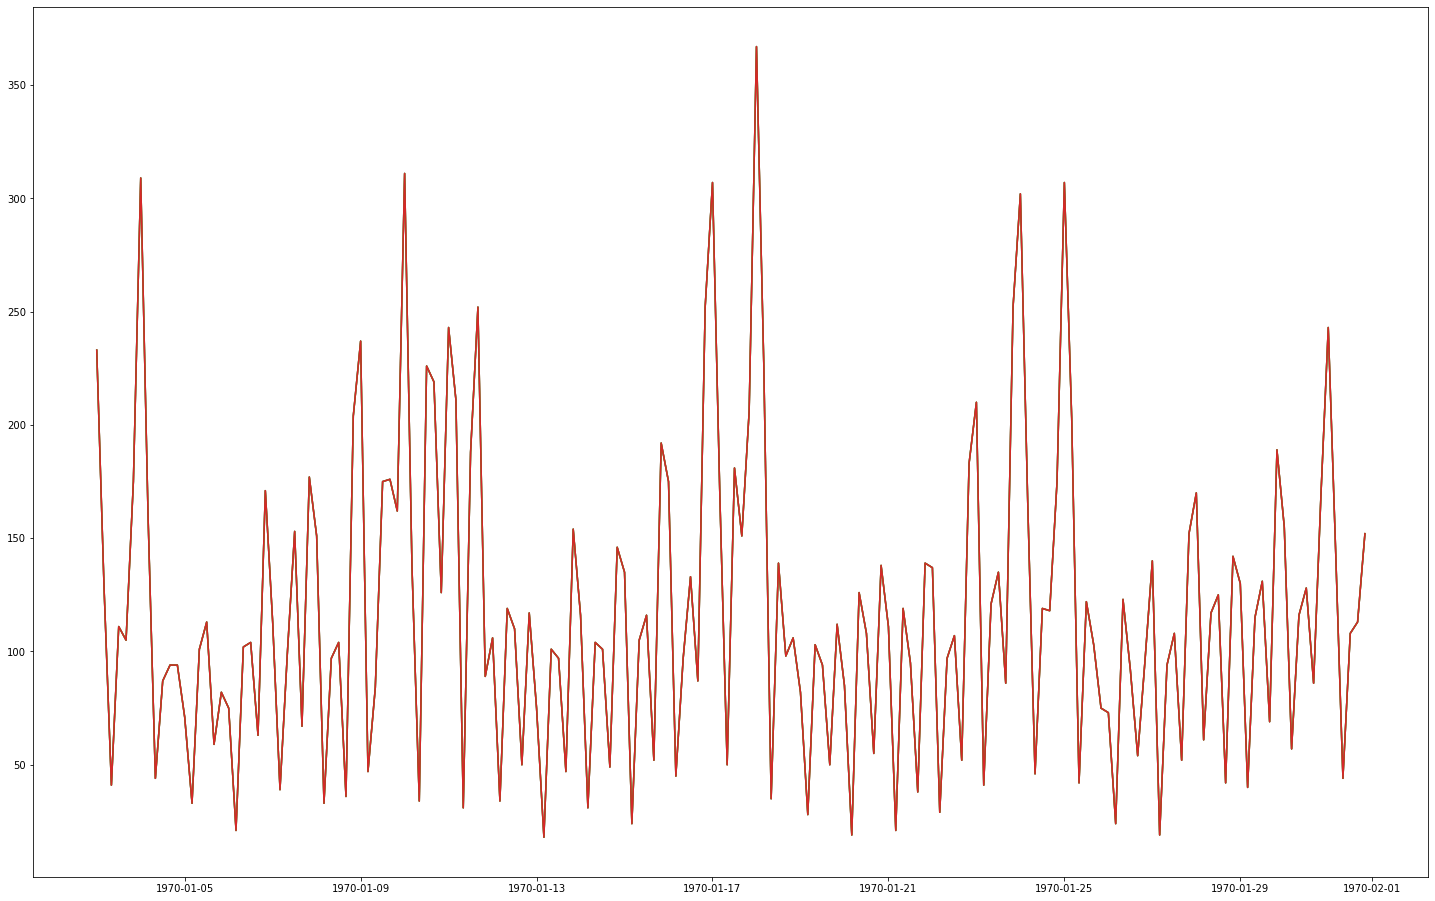

In [13]:
plt.figure(figsize=(25,16))
_=plt.plot(january_w_whole_month)

Over the whole month with 4 hour sampling windows ... there appears to be some weekly peaks for the weekend

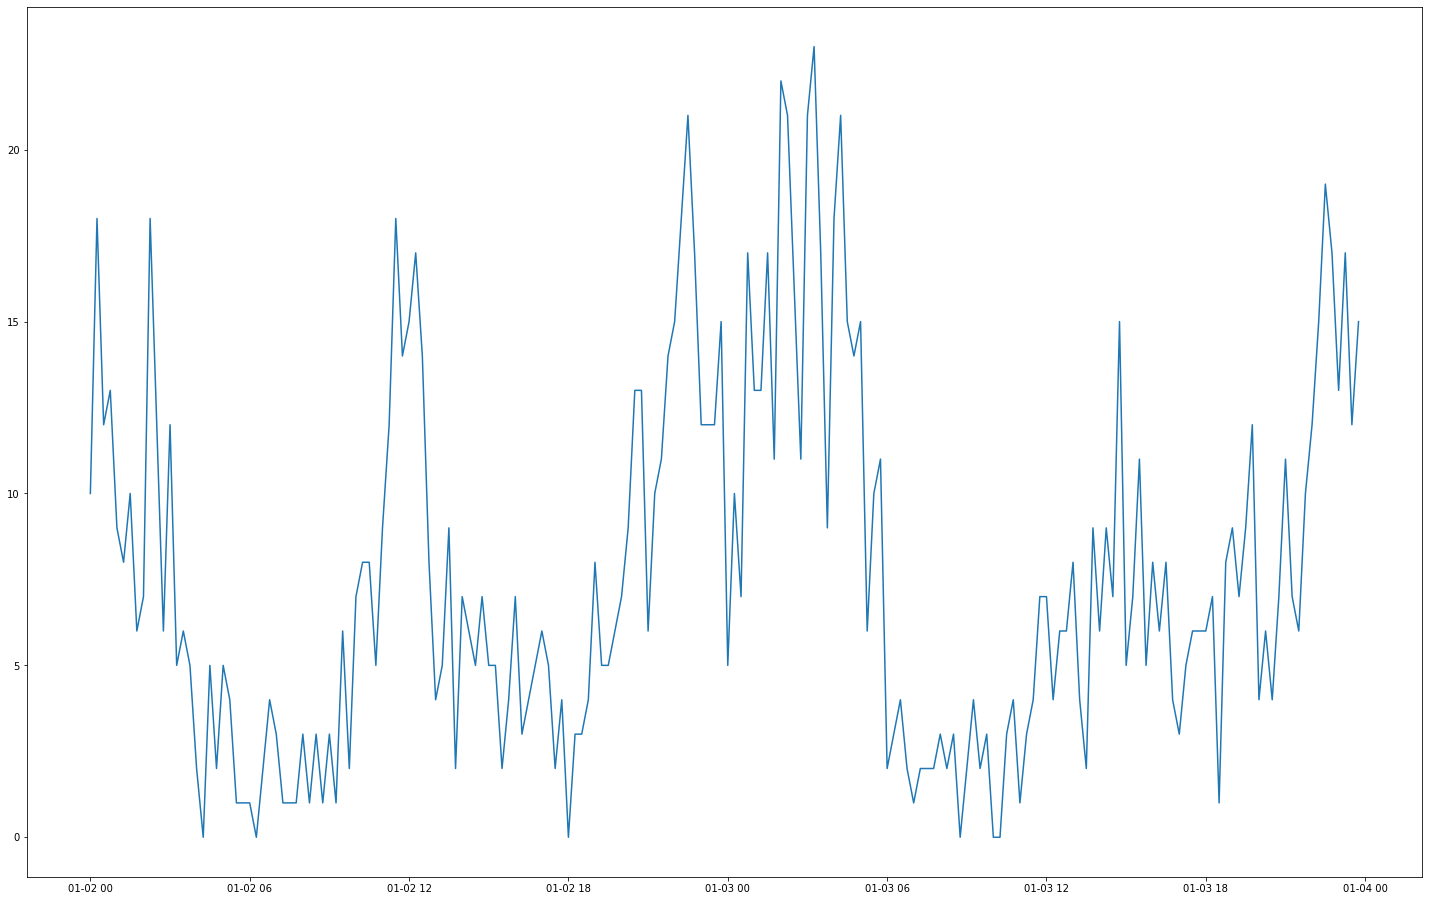

In [14]:
plt.figure(figsize=(25,16))
_=plt.plot(january_weekend)

The weekend pattern shows highest amount of activity in the evening hours through the early hours of the following day

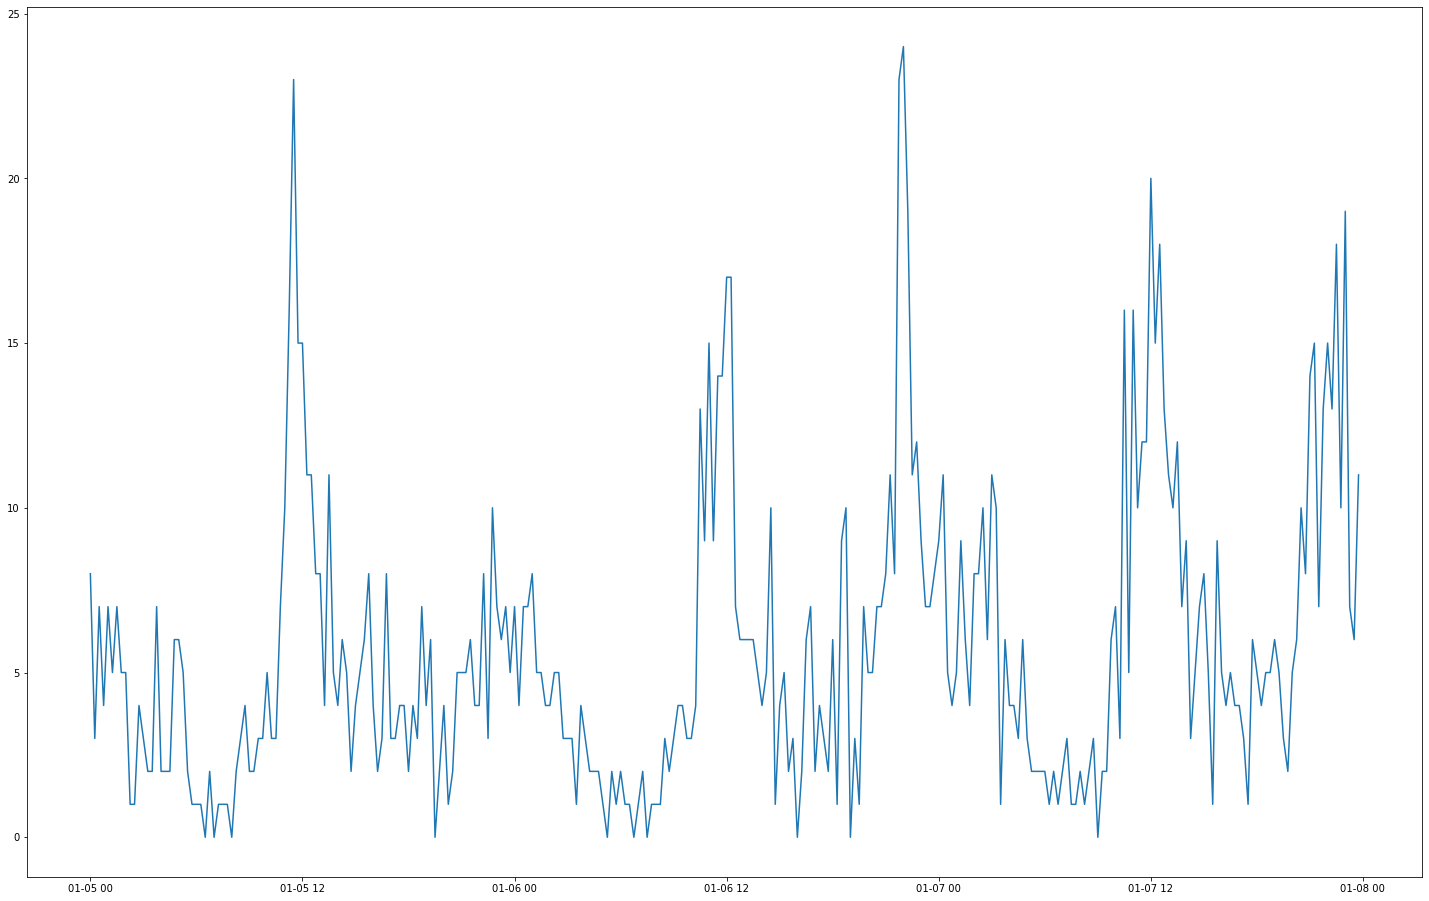

In [15]:
plt.figure(figsize=(25,16))
_=plt.plot(january_weekday)

Weekday activity is consistently less than weekends except for the peaks at around noon and the early hours.

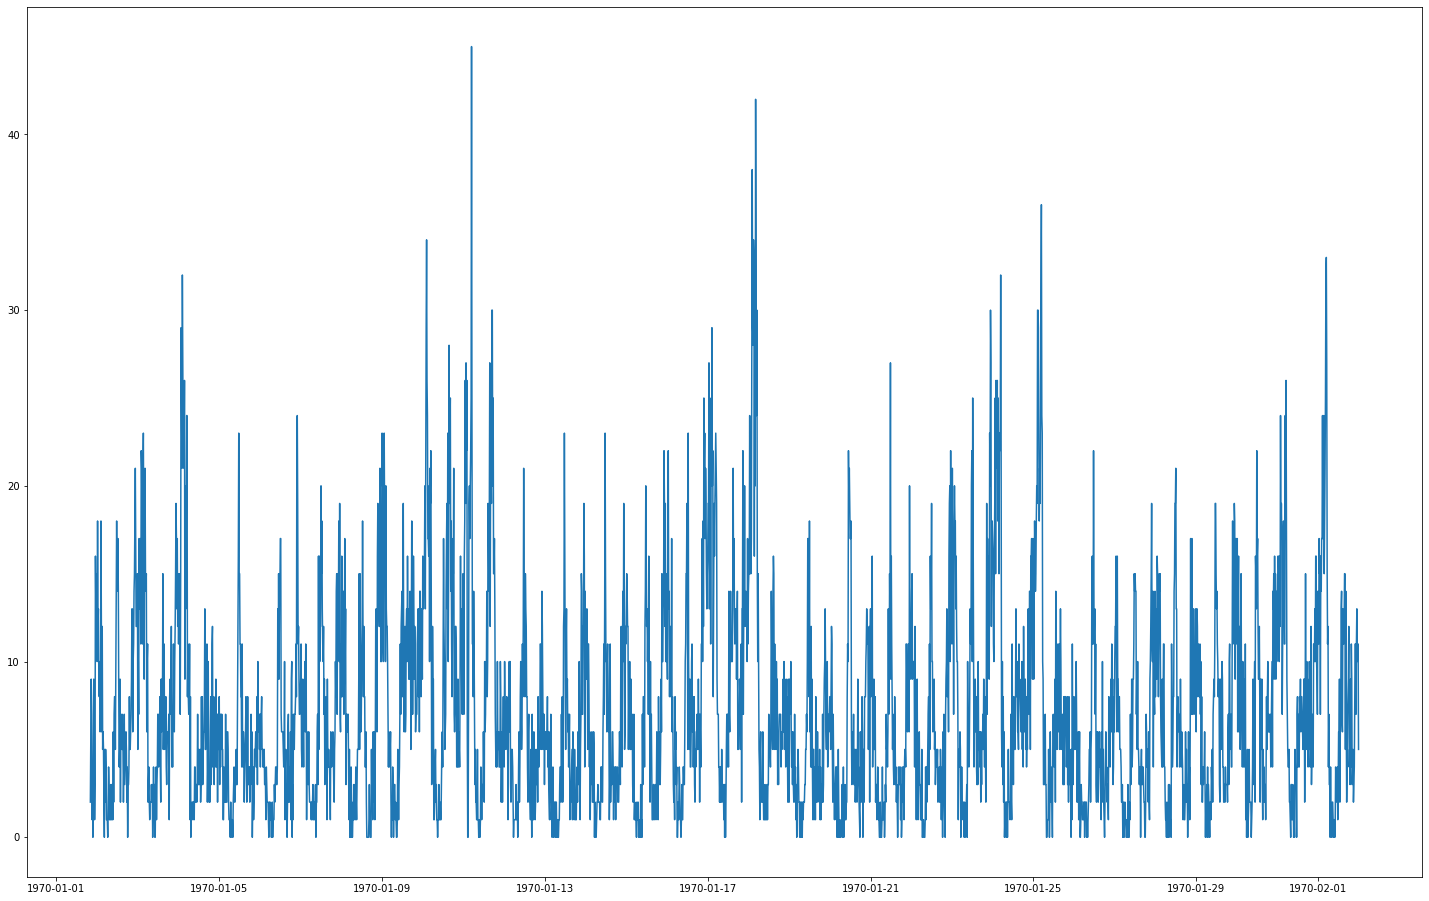

In [16]:
plt.figure(figsize=(25,16))
_=plt.plot(january)

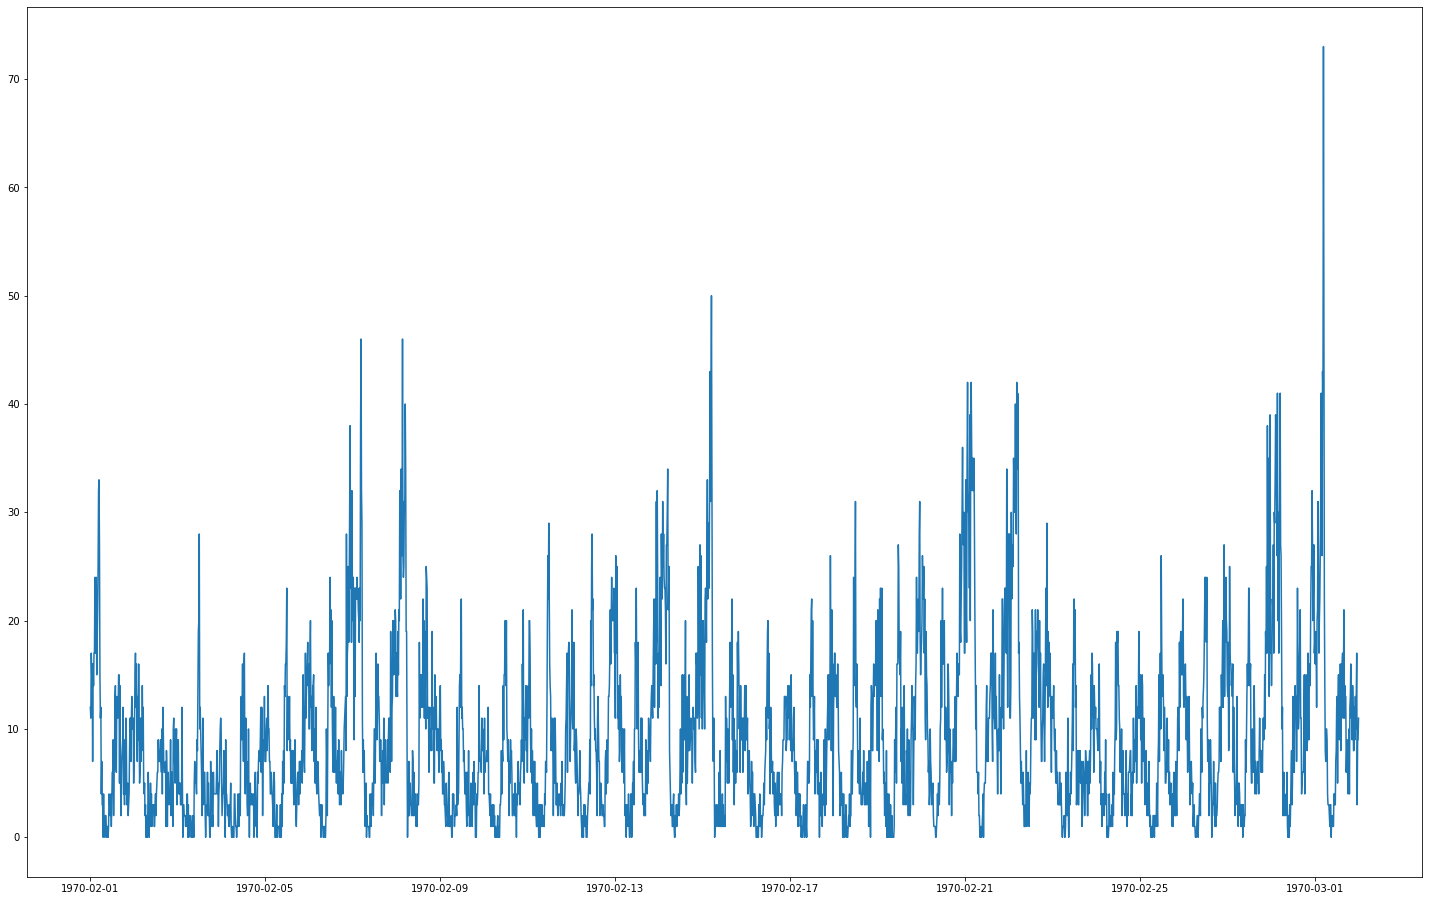

In [17]:
plt.figure(figsize=(25,16))
_=plt.plot(february)

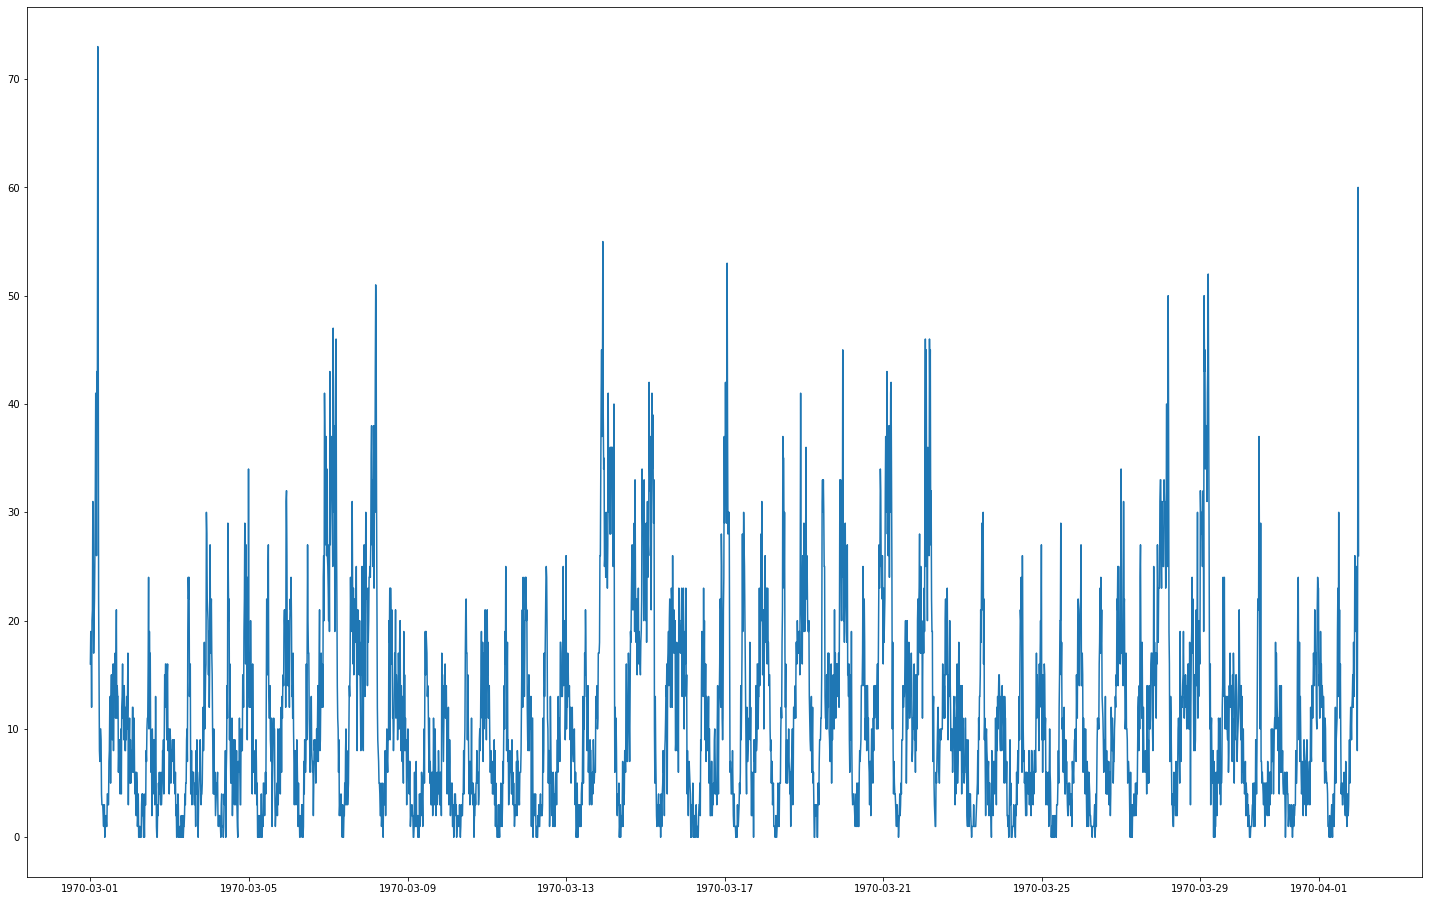

In [18]:
plt.figure(figsize=(25,16))
_=plt.plot(march)

The peaks and average activity levels tend to be higher in March compared to in January so it looks like the cyclic daily and weekly patterns is trending upward month over month as well.

In [19]:
login_df = login_df.set_index('login_time')

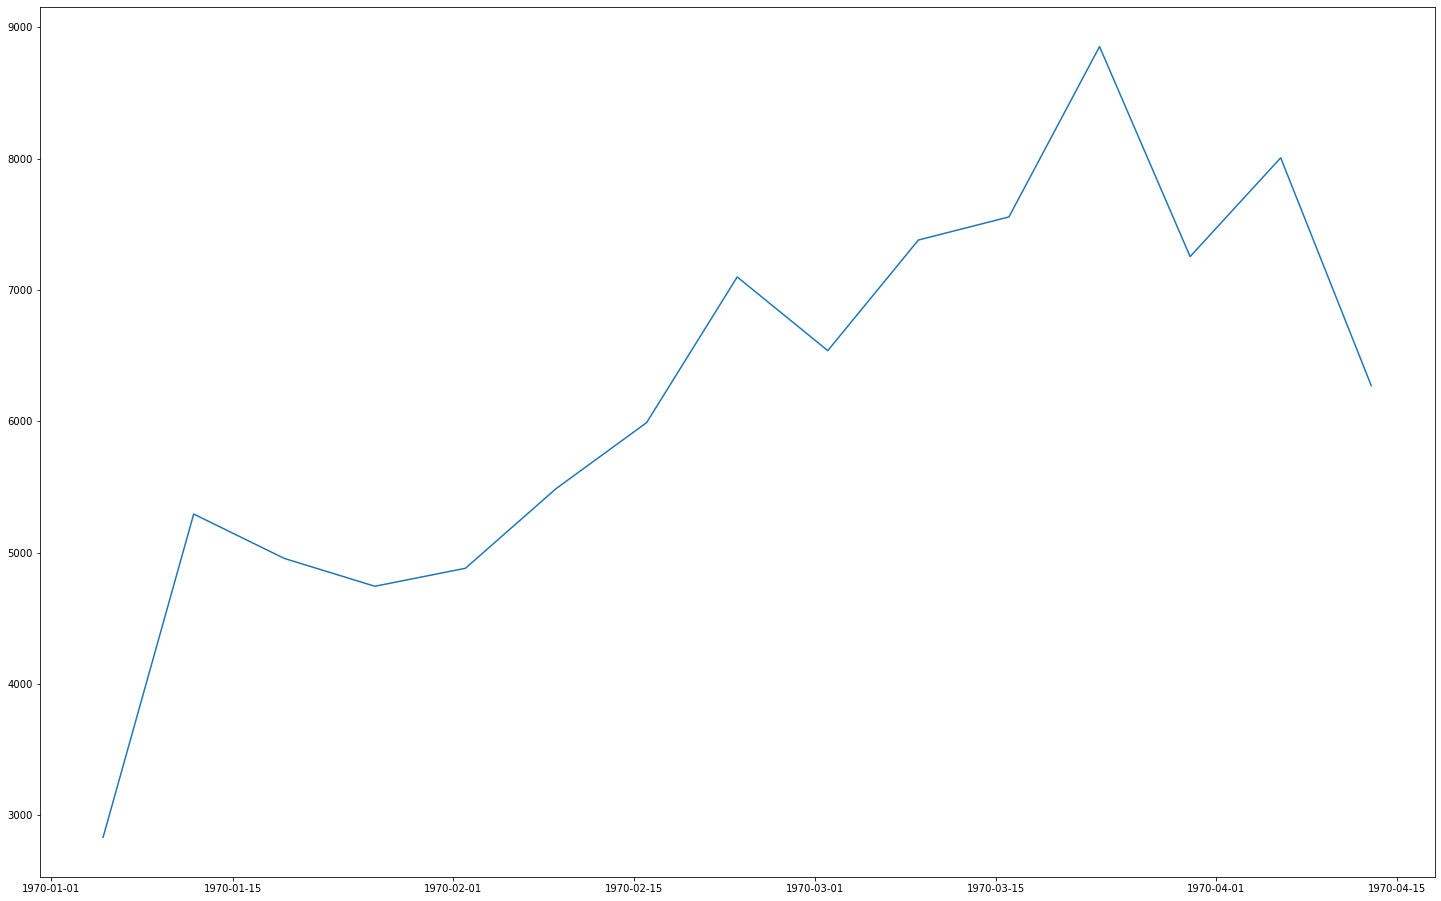

In [20]:
plt.figure(figsize=(25,16))
plt.plot(login_df.resample('W-MON')['count'].sum())

In [21]:
counts_by_month.tail()

month
1    21239
2    24673
3    33723
4    13507
Name: count, dtype: int64

**Last Couple of data points in april may be missing data for the full month since the dropoff in logins is fairly steep.**

# Part 2: Experiment and Metrics Design

## 1.What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

**I would look specifically for improvements in driving partner supply hours for the typical historical lows in either city. This means comparing the day time numbers in Gotham before and after the change and comparing night time numbers in Metropolis before and after the change. Since the goal is to make driver services more readily available in both cities, it makes sense to look for improvement at times their services are most needed.**

**The key number to assess then would be average surge before and after the policy change. Since the removal of the toll effectively removes a barrier for a driver to provide a ride, the drivers should theoretically be more incentived by the surge pricing to be available. This would be a pretty straight-forward measurement of increased pool of labor to supply rides between the two cities now free of toll costs thus allowing more drivers to contribute work with greater flexibility. I felt that this would be a better indicator of success than increase in average distance per trip since average surge increase would mean a greater level of availability of drivers at times when they're most needed wherever they're needed.**

## 2.Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

### a. Experiment Implementation

**I would add in a new boolean value column in the supply hour data for 'before/after toll change', in order to make the distinction clear. From there I would compare the average surge multiplier from before and set up a one tailed test to checking to see if the surge multiplier after is significantly greater than the surge multiplier before**

### b. Statistical testing

**I would use a one-tailed, t-test to see if the average surge multiplier has increased by a staistically meaningful measure after the bridge poll has been removed.**

### c. Results and recommendations

**If the tests do show that the average surge multiplier has increased by a statistically significant amount that would be great news! Barring exceptional circumstances or events in the time the toll refunds was rolled out, the increased average surge multiplier would show that on average, drivers were able to provide their services at times when demands were especially heavy while at the same time making a bit more on each of their rides. (win-win!)**

**Of course, one test does not yield an absolute, conclusive answer to the effects of this change. In order to investigate further, we should also consider seeing if driver city is a strong factor in availability during surge times. This would allow us to play with incentives a bit more and level out drivers in both cities as needed.**

# Part 3: Predictive Modeling

In [22]:
with open('ultimate_data_challenge.json','r') as read_file:
    ultimate_data = json.load(read_file)

In [23]:
ultimate_df = pd.DataFrame(ultimate_data)
ultimate_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

## Exploratory Data Analysis

###  Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). 

In [24]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Create masks for rows with missing records and making decision on these

Since phone is a category, once these are converted to dummies, missing values here will just have a 0 for each group thus making it pointless now to clean.

In [25]:
mask1 = ultimate_df['avg_rating_of_driver'].isnull()
mask2 = ultimate_df['avg_rating_by_driver'].isnull()

In [26]:
ultimate_df[mask1]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [27]:
ultimate_df[mask2]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,Winterfell,1,2014-01-10,5.0,1.0,2014-02-09,iPhone,0.0,False,0.0,6.28,NaN
274,Astapor,1,2014-01-25,2.0,4.0,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN
277,Winterfell,1,2014-01-25,NaN,1.0,2014-01-26,iPhone,0.0,False,0.0,1.82,NaN
536,Winterfell,1,2014-01-18,5.0,1.0,2014-02-08,Android,0.0,False,100.0,1.41,NaN
857,Winterfell,0,2014-01-11,4.0,1.0,2014-03-16,iPhone,0.0,False,0.0,0.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49249,King's Landing,0,2014-01-14,5.0,1.0,2014-06-19,iPhone,0.0,True,100.0,4.60,NaN
49376,Astapor,1,2014-01-20,4.0,1.0,2014-01-24,iPhone,0.0,False,100.0,3.01,NaN
49504,Winterfell,2,2014-01-24,5.0,1.0,2014-01-25,Android,0.0,False,100.0,0.75,NaN
49599,King's Landing,1,2014-01-14,5.0,1.0,2014-02-08,iPhone,0.0,False,100.0,2.48,NaN


I think for these two cases, it makes some sense to just fill the nan values with means from each respective field

In [28]:
ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(ultimate_df['avg_rating_by_driver'].mean())

In [29]:
ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(ultimate_df['avg_rating_of_driver'].mean())

In [30]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [31]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [32]:
# chart out anything that looks relevant

<Figure size 1800x1152 with 0 Axes>

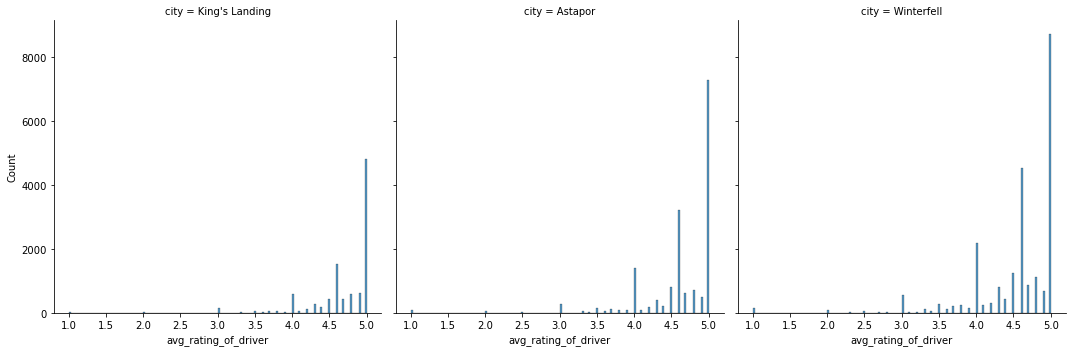

In [33]:
plt.figure(figsize=(25,16))
sns.displot(ultimate_df,x = 'avg_rating_of_driver',col='city')

<Figure size 1800x1152 with 0 Axes>

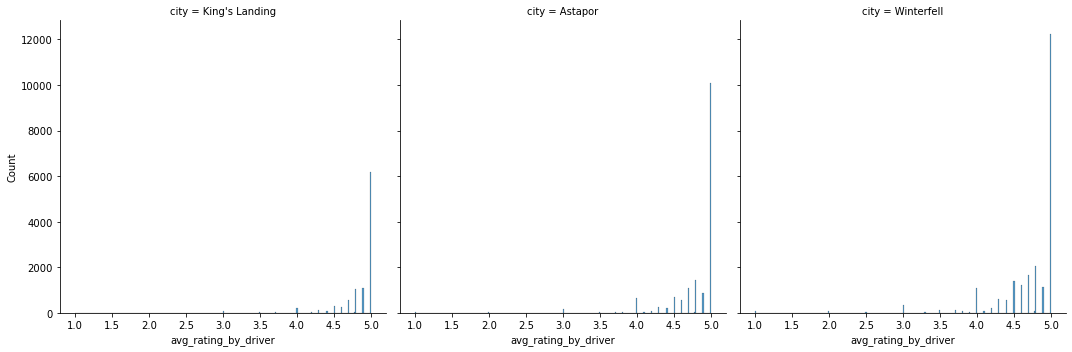

In [34]:
plt.figure(figsize=(25,16))
sns.displot(ultimate_df,x = 'avg_rating_by_driver',col = 'city')

<Figure size 1800x1368 with 0 Axes>

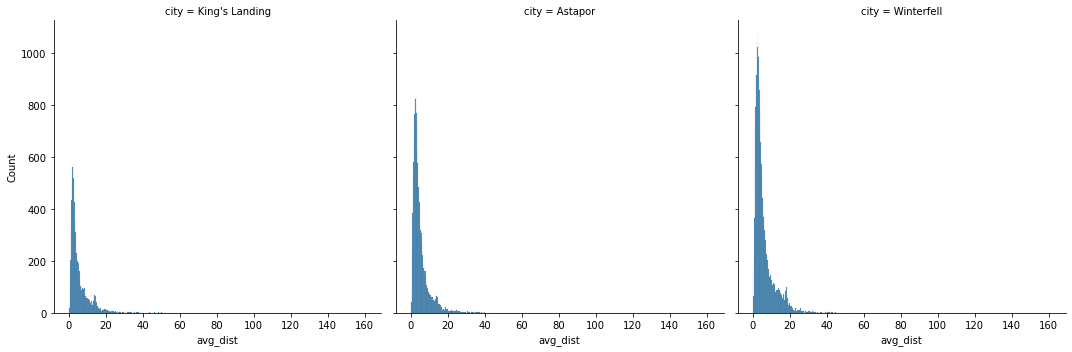

In [35]:
plt.figure(figsize=(25,19))
sns.displot(ultimate_df,x = 'avg_dist',col = 'city')

Althought it looks like Winterfell and Astapor may have more data compared to King's Landing, the distributions are similar and thus mostly comparable.

<Figure size 1800x1152 with 0 Axes>

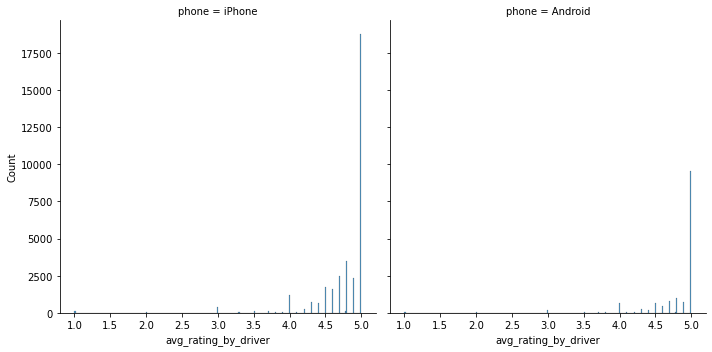

In [36]:
plt.figure(figsize=(25,16))
sns.displot(ultimate_df,x = 'avg_rating_by_driver',col = 'phone')

In [37]:
ultimate_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [38]:
ultimate_df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

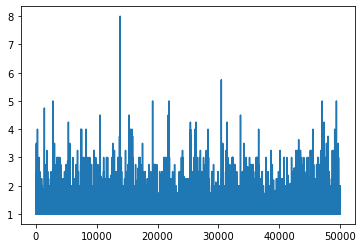

In [39]:
plt.plot(ultimate_df['avg_surge'])

### Feature Engineering

We should somehow leverage the date fields here as well... first that comes to mind is days since signup, days since last trip and days between last trip and signup...

Since the most recent trip date was july 1st, 2014. I will consider a user active if they took a trip on the platform in anytime during June 2014

In [40]:
max(ultimate_df['last_trip_date'])

'2014-07-01'

In [41]:
ultimate_df['last_trip_date']

0        2014-06-17
1        2014-05-05
2        2014-01-07
3        2014-06-29
4        2014-03-15
            ...    
49995    2014-06-05
49996    2014-01-25
49997    2014-05-22
49998    2014-01-15
49999    2014-04-20
Name: last_trip_date, Length: 50000, dtype: object

{'whiskers': [<matplotlib.lines.Line2D at 0x220eef3eaf0>,
 'caps': [<matplotlib.lines.Line2D at 0x220ef0db1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x220eef3e790>],
 'medians': [<matplotlib.lines.Line2D at 0x220ef0db8b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x220ef0dbc10>],
 'means': []}

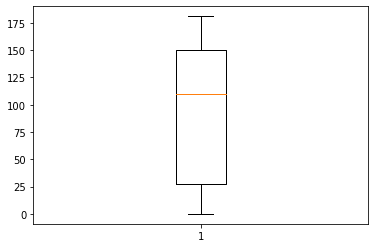

In [42]:
#days gap between last trip and signup
last_trip_signup_gap = pd.to_datetime(ultimate_df['last_trip_date']) - pd.to_datetime(ultimate_df['signup_date'])
last_trip_signup_gap = (last_trip_signup_gap/np.timedelta64(1,'D')).astype(int)
plt.boxplot(last_trip_signup_gap)

{'whiskers': [<matplotlib.lines.Line2D at 0x220ef134c40>,
 'caps': [<matplotlib.lines.Line2D at 0x220ef141340>,
 'boxes': [<matplotlib.lines.Line2D at 0x220ef1348e0>],
 'medians': [<matplotlib.lines.Line2D at 0x220ef141a00>],
 'fliers': [<matplotlib.lines.Line2D at 0x220ef141d60>],
 'means': []}

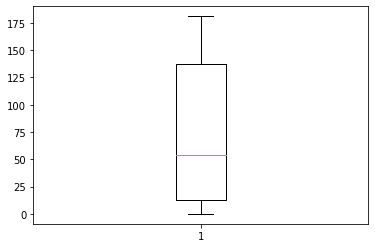

In [43]:
#days gap since most recent trip (assuming last trip in the group is the most recent day)
days_since_last_trip = pd.to_datetime(max(ultimate_df['last_trip_date'])) - pd.to_datetime(ultimate_df['last_trip_date'])
days_since_last_trip = (days_since_last_trip/np.timedelta64(1,'D')).astype(int)
plt.boxplot(days_since_last_trip)

{'whiskers': [<matplotlib.lines.Line2D at 0x220ef192d00>,
 'caps': [<matplotlib.lines.Line2D at 0x220ef1a1400>,
 'boxes': [<matplotlib.lines.Line2D at 0x220ef1929a0>],
 'medians': [<matplotlib.lines.Line2D at 0x220ef1a1ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x220ef1a1e20>],
 'means': []}

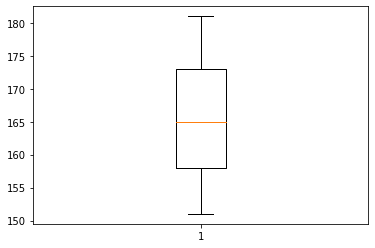

In [44]:
#days since signup
days_since_signup = pd.to_datetime(max(ultimate_df['last_trip_date'])) - pd.to_datetime(ultimate_df['signup_date'])
days_since_signup = (days_since_signup/np.timedelta64(1,'D')).astype(int)
plt.boxplot(days_since_signup)

In [45]:
day_features = pd.DataFrame({'last_trip_signup_gap':last_trip_signup_gap,'days_since_last_trip':days_since_last_trip,'days_since_signup':days_since_signup})
day_features

,last_trip_signup_gap,days_since_last_trip,days_since_signup
0,143,14,157
1,96,57,153
2,1,175,176
3,170,2,172
4,47,108,155
...,...,...,...
49995,131,26,157
49996,1,157,158
49997,111,40,151
49998,1,167,168


In [48]:
# assigning active driver values accordingly...

In [46]:
#creating mask to limit only those who've given a ride in previous 30 days back in June 2014
#mask = (ultimate_df['last_trip_date']>='2014-06-01') & (ultimate_df['last_trip_date']<'2014-08-01')
mask = pd.to_datetime(ultimate_df['last_trip_date'])> pd.to_datetime(max(ultimate_df['last_trip_date']))-pd.to_timedelta("30day")

In [47]:
# set everyone inactive by default
ultimate_df['active'] = 0

In [48]:
#active only if mask fits
ultimate_df.loc[mask,'active'] = 1

In [49]:
ultimate_df['active'].value_counts()

0    31690
1    18310
Name: active, dtype: int64

### What fraction of the observed users were retained?


In [50]:
print(str(round(sum(ultimate_df['active']==1)/len(ultimate_df)*100,2)) + '% of the drivers have been retained on the platform') 

36.62% of the drivers have been retained on the platform


## 2. Predictive Modeling

### predict whether a user will be active in their 6th month on the system

As with any other sort of classification problem, I always start with logstic regression as the baseline for performance simply because of the ease of interpretability and see if performance can be improved via ensemble methods and some hyperparameter tuning

In [51]:
# convert phone and city into categorical variable columns before regressing
dummy_df = pd.get_dummies(ultimate_df[['phone','city']])
dummy_df.head()

,phone_Android,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell
0,0,1,0,1,0
1,1,0,1,0,0
2,0,1,1,0,0
3,0,1,0,1,0
4,1,0,0,0,1


In [52]:
full_df = pd.concat([ultimate_df,dummy_df,day_features],axis = 1)
full_df = full_df.drop(['city','phone','last_trip_date','signup_date'],axis = 1)
full_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,phone_Android,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell,last_trip_signup_gap,days_since_last_trip,days_since_signup
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1,0,1,0,1,0,143,14,157
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,1,0,1,0,0,96,57,153
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0,0,1,1,0,0,1,175,176
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,0,1,0,1,0,170,2,172
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,1,0,0,0,1,47,108,155


In [53]:
X = full_df.drop(['active'],axis=1)
y = full_df['active']

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.api as sm

In [55]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4, random_state = 42)

In [56]:
mlr = LogisticRegression(random_state = 42).fit(X_train,y_train)

In [57]:
y_pred = mlr.predict(X_test)
mlr.score(X_test,y_test)

0.997

In [58]:
mlr.score(X_train,y_train)

0.9963666666666666

In [59]:
pd.DataFrame(zip(X.columns, np.transpose(mlr.coef_)), columns=['features', 'coef']) 

,features,coef
0,trips_in_first_30_days,[0.08934825808174625]
1,avg_rating_of_driver,[1.110067456449241]
2,avg_surge,[0.8526295680532308]
3,surge_pct,[-0.018346937072594615]
4,ultimate_black_user,[0.808678089015772]
5,weekday_pct,[0.03467560167122879]
6,avg_dist,[0.007491828989159571]
7,avg_rating_by_driver,[2.543996219568242]
8,phone_Android,[-0.0031462708524515803]
9,phone_iPhone,[0.8673823326853812]


In [60]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12704
           1       1.00      1.00      1.00      7296

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [61]:
cm = metrics.confusion_matrix(y_test,y_pred)
cm

array([[12678,    26],
       [   34,  7262]], dtype=int64)

Leverage statsmodels in order to get more interpretability

In [62]:
lo_mo = sm.Logit(y_train,X_train.astype(float))
result = lo_mo.fit_regularized()
print(result.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2348540225105932e-10
            Iterations: 230
            Function evaluations: 247
            Gradient evaluations: 230
                           Logit Regression Results                           
Dep. Variable:                 active   No. Observations:                30000
Model:                          Logit   Df Residuals:                    29984
Method:                           MLE   Df Model:                           15
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                   1.000
Time:                        15:59:45   Log-Likelihood:            -3.7046e-06
converged:                       True   LL-Null:                       -19722.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

**Trying out random forest**

In [64]:
from sklearn.ensemble import RandomForestClassifier as rfc

In [65]:
rf_model = rfc(random_state = 42, class_weight = 'balanced')
rf_model.fit(X_train,y_train)
y_pred_rfc = rf_model.predict(X_test)

In [66]:
training_score = rf_model.score(X_train,y_train)
training_score

1.0

In [67]:
testing_score = rf_model.score(X_test,y_test)
testing_score

1.0

In [68]:
print(metrics.classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12704
           1       1.00      1.00      1.00      7296

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [69]:
key_features = pd.DataFrame({'RF Importance Coefficient':rf_model.feature_importances_},index=X.columns)
key_features.sort_values('RF Importance Coefficient',ascending=False)

,RF Importance Coefficient
days_since_last_trip,0.536461
last_trip_signup_gap,0.360121
avg_rating_by_driver,0.036815
surge_pct,0.013407
avg_surge,0.010619
city_King's Landing,0.010506
weekday_pct,0.008914
days_since_signup,0.007077
phone_iPhone,0.004362
phone_Android,0.003835


## 3. Analysis / Insights

Despite my best attempts, I can't find anything glaring which might be incorrectly included in the model making the accuracy so high. Therefore I can conclude that this model and significant factors included in both the logistic regression model as well as the random forest model as valid. 

From the random forest model, we can gather that the key factors are the days which have passed since the last trip completed, the days between sign up and last trip and average rating from driver. I think this assessment makes sense as retention can essentially be defined by the two former factors, ie the fewer days since the last trip and the larger then last trip to signup gap the better.